# Modules

In [29]:
import zogytf
import numpy as np
import matplotlib.pyplot as plt

from zogytf import fakes
from astropy.io import fits
from astrobject import photometry
from scipy.spatial.distance import cdist
from astrobject import baseobject
from astropy import units

# Input

In [2]:
your_path = '/home/nicolas/Work/Data/ztf/ZOGYexample/'
FILE_IN = your_path + "ztf_20180216349352_000519_zr_c09_o_q3_newscibmtch.fits"
ztfimg = photometry.Image(FILE_IN, background=0)
hdul = fits.open(FILE_IN)
header = hdul[0].header

### To show, select and convert to code by pressing y

ztfimg.show()

### Define zoomtarget: how to get ra, dec inside boundaries?

sn_ra, sn_dec = 8.1570973, 41.31573905
sn_target = baseobject.get_target(name="SN_test", ra=sn_ra, dec=sn_dec)
ztfimg.set_target(sn_target)

### To show, select and convert to code by pressing y

ztfimg.show(zoomon="target")

### Catalogue selection

In [3]:
ztfimg.download_catalogue("gaia")

### To show, select and convert to code by pressing y

ztfimg.show(show_catalogue=True)#, zoomon="target")

## Select isolated stars depending on mag and arcsecs isolation

In [4]:
arcsecs = 20
mag_range = [14, 20]
ztfimg.catalogue.define_around(arcsecs*units.arcsec)
maskiso = ztfimg.catalogue.get_mask(catmag_range=mag_range,
                                    isolated_only=True)

/home/nicolas/.installs/anaconda3/lib/python3.7/site-packages/astrobject-0.8.6-py3.7.egg/astrobject/catalogue/basecatalogue.py:541: RuntimeWarning: invalid value encountered in greater_equal
/home/nicolas/.installs/anaconda3/lib/python3.7/site-packages/astrobject-0.8.6-py3.7.egg/astrobject/catalogue/basecatalogue.py:541: RuntimeWarning: invalid value encountered in less_equal


### Take values

In [5]:
ra, dec, mag, color = ztfimg.catalogue.get(["ra", "dec", "mag", "BP-RP"],
                                          mask=maskiso)
x,y = ztfimg.coords_to_pixel(ra,dec).T

### Show it

%matplotlib widget
plt.close()
ax = ztfimg.show()['ax']
ax.scatter(x,y, marker="x", color="C1")

# Select star to duplicate

### _star_idx_ is the star closest to the center

In [12]:
center_point = np.asarray(np.shape(ztfimg.rawdata))/2
stars_coords = np.dstack([x.ravel(),y.ravel()])[0]

#star_idx = cdist([center_point], stars_coords).argmin()

### Or you can set it yourself with _star_idx = int_

In [19]:
star_idx = 1000

## Actual patching

In [20]:
patch_size = 23
data_patch = fakes.get_patch(ztfimg.rawdata,
                             x[star_idx], y[star_idx],
                             patch_size, patch_size)
patch = fakes.StarPatch(data_patch)

#### Plot the patch if you want

plt.close()
fig, ax = plt.subplots()
im = ax.imshow(data_patch, **prop)#, vmin=120, vmax=1500)

### Plot the ztfimg around the future patch, to see before/after

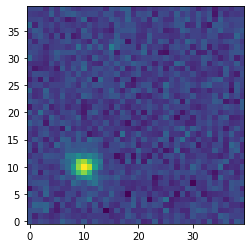

In [22]:
view_x_inc = 10
view_y_inc = 10
view_size = 40
ztf_zoomed = fakes.get_patch(ztfimg.rawdata,
                             x[star_idx]+view_x_inc,
                             y[star_idx]+view_y_inc,
                             view_size, view_size)
plt.close()
fig, ax = plt.subplots()
prop={'interpolation': 'nearest',
      'origin': 'lower',
      'cmap': 'viridis'}
im = ax.imshow(ztf_zoomed, **prop)#, vmin=120, vmax=1500)

## Choose the patch's _x, y_ translations, and inject it

In [23]:
x_inc, y_inc = 20, 20
ztf_patched = patch.inject_in_image(ztfimg.rawdata,
                                    x[star_idx]+x_inc,
                                    y[star_idx]+y_inc)

#### Get _x, y_ and _ra, dec_ of new star

In [28]:
x_new, y_new = x[star_idx]+x_inc, y[star_idx]+y_inc
xy_new = [x_new, y_new]

ra_new, dec_new = ztfimg.pixel_to_coords(x_new, y_new)
radec_new = [ra_new, dec_new]

print('xy_new =', xy_new)
print('radec_new =', radec_new)

xy_new = [1710.1536345841566, 822.1381841907526]
radec_new = [145.47729522608248, 12.483558931690714]


## Visualize change

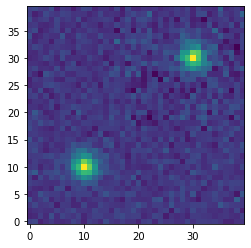

In [11]:
ztf_patched_zoomed = fakes.get_patch(ztf_patched,
                                     x[star_idx]+view_x_inc,
                                     y[star_idx]+view_y_inc,
                                     view_size, view_size)

plt.close()
fig, ax = plt.subplots()
im = ax.imshow(ztf_patched_zoomed, **prop)#, vmin=120, vmax=1500)

# Create new fake.fits from modified data

#### Convert to cell (y) to run

FILE_OUT = FILE_IN[:-16] + 'fake_' + FILE_IN[-16:]
fake_sci = fits.HDUList(fits.PrimaryHDU(data=ztf_patched,
                                        header=header))
fake_sci.writeto(FILE_OUT, overwrite=True)